In [69]:
## importing neccessary libray
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVDpp, accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering
import matplotlib
import pickle
import pandas as pd
import ast
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [70]:
## Loading DataSet into pandas

df_ratings = pd.read_csv(r'D:\ml-latest-small\ratings.csv')

In [71]:

df_ratings.head()


,userId,productId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [72]:
df_ratings.tail()

,userId,productId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [73]:
df_reviews =  pd.read_csv(r'D:\Reviews.csv')

In [74]:
df_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [75]:
df_reviews.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [76]:
#shape of data 
shape_Data = df_reviews.shape
print('Data set contains "{x}" number of rows and "{y}" number of columns' .format(x=shape_Data[0],y=shape_Data[1]))

Data set contains "568454" number of rows and "10" number of columns


<AxesSubplot:>

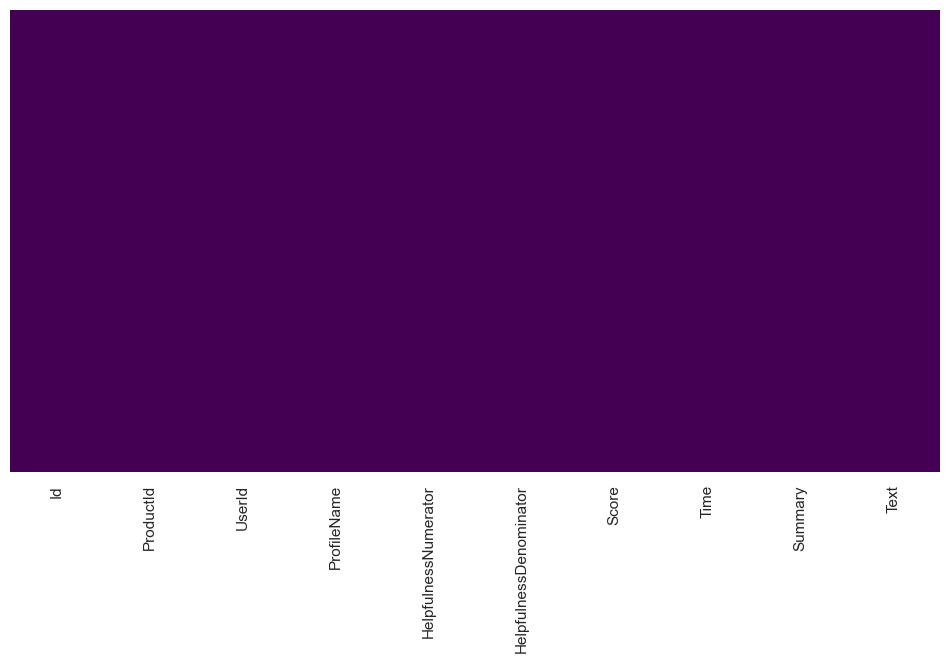

In [77]:
#null check
sns.heatmap(df_reviews.isnull(),yticklabels=False,cbar=False,cmap='viridis')

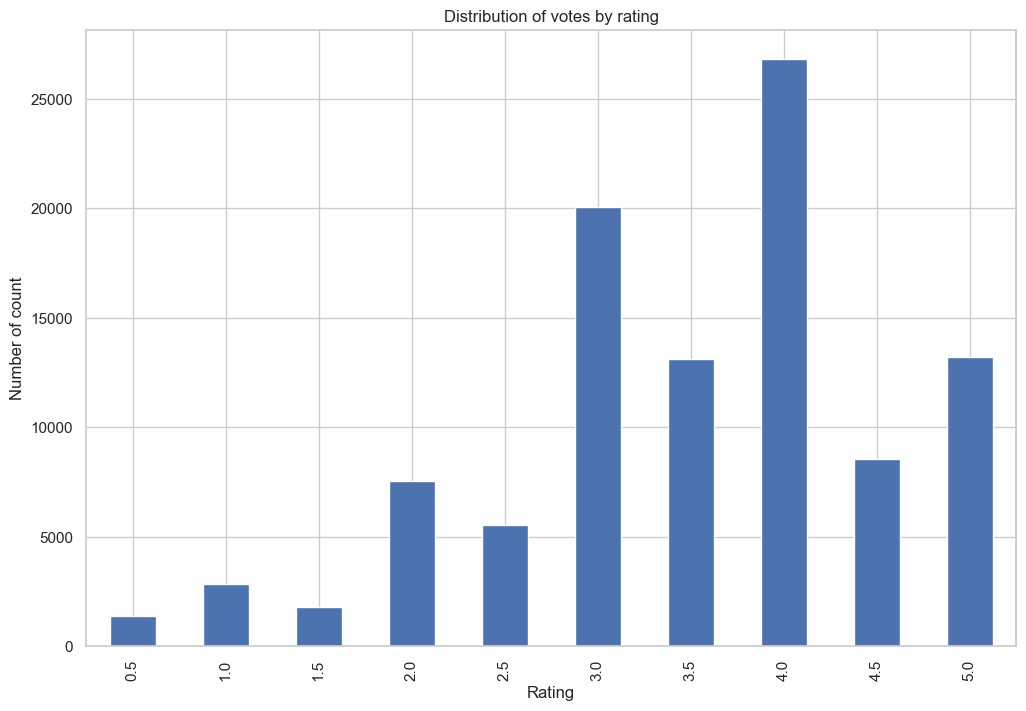

In [78]:
ratings_count = df_ratings['rating'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(12,8))

ax = ratings_count.plot.bar()

ax.set_xlabel("Rating")

ax.set_ylabel("Number of count");

ax.set_title("Distribution of votes by rating");

[Text(0.5, 0, 'Rating'), Text(0, 0.5, 'Count')]

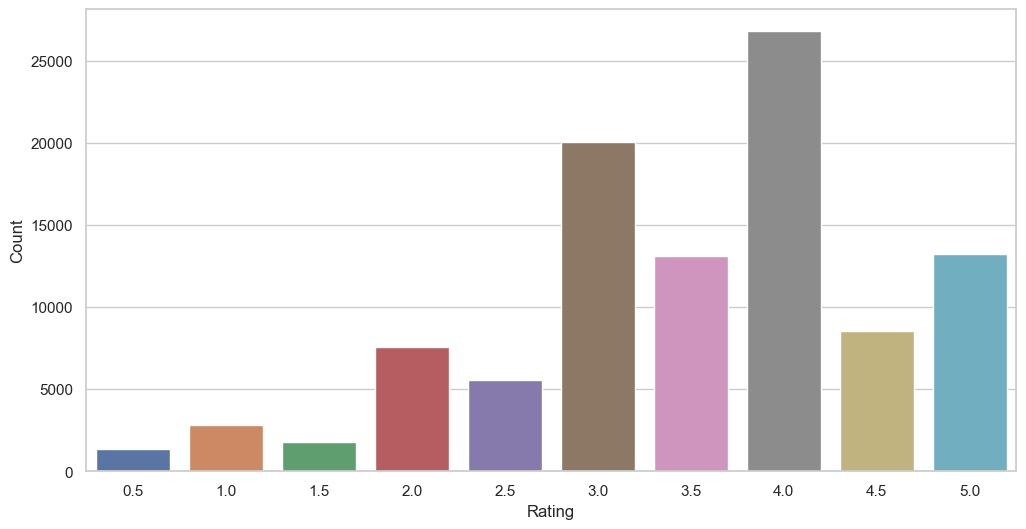

In [79]:
# Rating frequency

sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('whitegrid')
ax = sns.countplot(x='rating', data=df_ratings)
ax.set(xlabel='Rating', ylabel='Count')

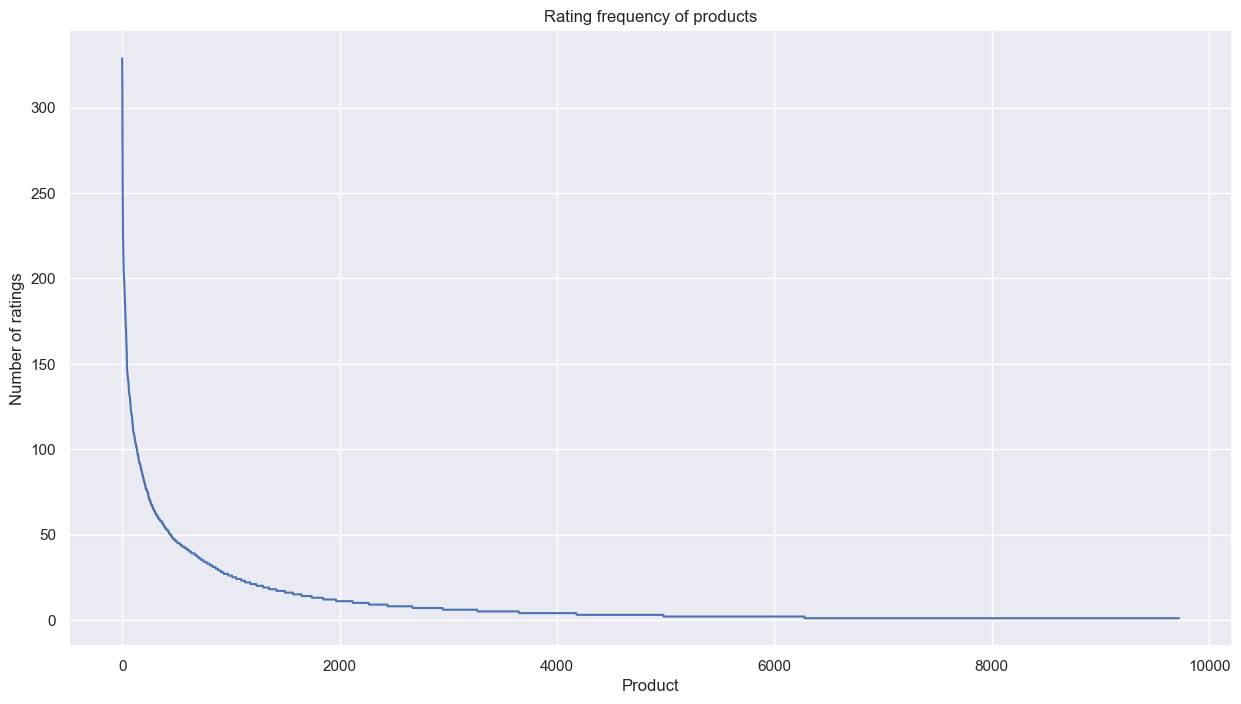

In [80]:
df = df_ratings[['productId','userId']].groupby(['productId']).agg(['count']).sort_values(('userId','count'),ascending=False)

plt.figure(figsize=(15,8))

sns.set_style("darkgrid")

sns.lineplot(data=df[('userId', 'count')].values)

plt.title("Rating frequency of products")

plt.xlabel("Product")

plt.ylabel("Number of ratings");

In [81]:
min_ratings = 20

print("Number of products which have more than {} ratings: {}".format(min_ratings, len(df[df[('userId', 'count')]>=min_ratings])))

Number of products which have more than 20 ratings: 1297


In [82]:
df_top_products = df[df[('userId', 'count')]>=min_ratings]

df_ratings_with_top_products = df_ratings[df_ratings['productId'].isin(list(df_top_products.index))]

In [83]:
## Excluding users that have not rated atleast 20 products
min_products_rated = 20

df_users = df_ratings_with_top_products[['productId','userId']].groupby(['userId']).agg(['count']).sort_values(('productId','count'),ascending=False)

df_top_rating_users = df_users[df_users[('productId', 'count')]>=min_products_rated]

top_rating_users = list(df_top_rating_users.index)

df_final=df_ratings_with_top_products[df_ratings_with_top_products['userId'].isin(top_rating_users)]

In [84]:
df_user_item_matrix = df_final.pivot(index='productId',columns='userId',values='rating').fillna(0)

In [85]:
#Matrix for the Algo
user_item_matrix_sparse = csr_matrix(df_user_item_matrix.values)

In [86]:
## Fill missing values with 0
df_user_item_matrix = df_final.pivot(index='productId',columns='userId',values='rating').fillna(0)

In [87]:
## Sparse Matrix Representation

user_item_matrix_sparse = csr_matrix(df_user_item_matrix.values)

In [88]:
## train the knn nearest neighbors
model = NearestNeighbors(n_neighbors=30, metric='cosine', algorithm='brute', n_jobs=-1)
model.fit(user_item_matrix_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=30)

In [89]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [90]:
## Store product and Ids in Dictonary
index_to_reviews = dict()

df_ids_prodcuts = df_reviews.set_index('Id').loc[df_user_item_matrix.index]

count = 0

for index, row in df_ids_prodcuts.iterrows():

    index_to_reviews[count]=row['ProductId']

    count +=1

In [96]:
## Recommender Function


def recommender(model, user_item_matrix_sparse,  df_reviews, number_of_recommendations, product_index):

    product_id = index_to_reviews[product_index]

    dist, ind = model.kneighbors(user_item_matrix_sparse[product_index], n_neighbors=number_of_recommendations+1)

    dist = dist[0].tolist()

    ind = ind[0].tolist()

    ids = []

    for index in ind:

        ids.append(index_to_reviews[index])

    recommendations = list(zip(ids,dist))    

    # sort recommendations

    recommendations_sorted = sorted(recommendations, key = lambda x:x[1])

    # reverse recommendations, leaving out the first element 

    recommendations_sorted.reverse()

    recommendations_sorted = recommendations_sorted[:-1]

    print("Recommendations for product {}: ".format(product_id))

    count = 0

    for (id, distance) in recommendations_sorted:

        count += 1

        print('{}. {}, recommendation score = {}'.format(count, id, round(distance,3)))

recommender(model, user_item_matrix_sparse, df_reviews, 20,50)

Recommendations for product B000ITVLE2: 
1. B0002567IW, recommendation score = 0.498
2. B003VTN95K, recommendation score = 0.497
3. B00067AD4U, recommendation score = 0.493
4. B001EPQ0J0, recommendation score = 0.488
5. B001EO5ZMO, recommendation score = 0.484
6. B003YXWAF8, recommendation score = 0.474
7. B001UJEN6C, recommendation score = 0.471
8. B005P0HHGK, recommendation score = 0.463
9. B001KUUNP6, recommendation score = 0.447
10. B000G6RYNE, recommendation score = 0.446
11. B0037ZFEW4, recommendation score = 0.446
12. B0067LDV66, recommendation score = 0.441
13. B000ITVLE2, recommendation score = 0.426
14. B000G6RYNE, recommendation score = 0.423
15. B003YXWAF8, recommendation score = 0.398
16. B001UJEN6C, recommendation score = 0.387
17. B000G6RYNE, recommendation score = 0.386
18. B000G6RYNE, recommendation score = 0.381
19. B000G6RYNE, recommendation score = 0.364
20. B00067AD4U, recommendation score = 0.304
